## **Image2Style** 구현

"Image2StyleGAN: How to Embed Images Into the StyleGAN Latent Space?" 에서 제시한 method 구현

-> StyleGAN을 통해 원하는 이미지를 만들어 낼 수 있는 **latent vector** 찾기

In [1]:
# Please first run -> git clone https://github.com/ChoiDae1/StyleGAN_Project + unzip PyTorch-StyleGAN-Face-Editting\weights\karras2019stylegan-ffhq-1024x1024.zip


In [44]:
import os

print(os.getcwd())
#os.chdir('PyTorch-StyleGAN-Face-Editting')

c:\Users\User\Desktop\고려대학교\동아리\KUBIG\CV 세션\StyleClip 프로젝트\PyTorch-StyleGAN-Face-Editting


### **Load required libraries**

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import models 
from torchvision import transforms
from torchvision.utils import save_image

from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

### **Pretrained StyleGAN** 불러오기

Flickr-Faces-HQ Dataset (FFHQ) 데이터셋에서 pretrain

In [46]:
from stylegan_model import G_mapping
from stylegan_model import G_synthesis

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
resolution = 1024
weight_file = 'weights/karras2019stylegan-ffhq-1024x1024.pt'

g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis(resolution=resolution))    
]))
g_all.load_state_dict(torch.load(weight_file, map_location=device))
g_all.eval()
g_all.to(device)
 
g_mapping, g_synthesis = g_all[0], g_all[1]

In [47]:
# Read an image from a file
def image_reader(image_path, resize=None):
    with open(image_path, "rb") as f:
        image = Image.open(f)
        image = image.convert("RGB")
    if resize != None:
        image = image.resize((resize, resize))
    transform = transforms.Compose([
        transforms.ToTensor() # [0, 1]
    ])
    image = transform(image)
    image = image.unsqueeze(0) # (N, C, H, W)
    return image


# Show a torch image
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    gray_scale = False
    if image.shape[0] == 1:
        gray_scale = True
    image = transforms.ToPILImage()(image)
    if gray_scale:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()


# Change the display resolution
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

### **사용할 이미지 불러오기**

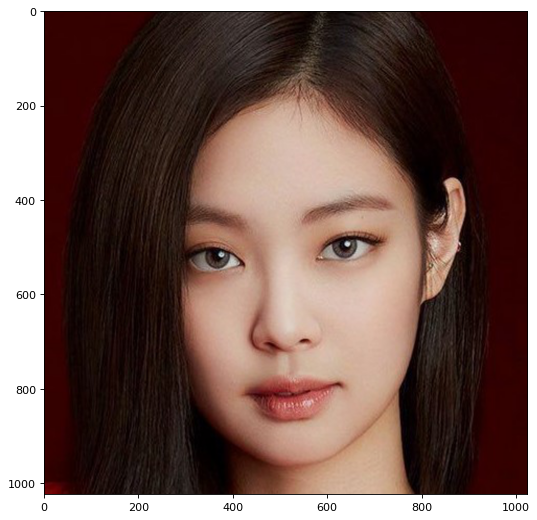

In [150]:
img_path = 'images/제니.jpg'
sample_img = image_reader(img_path, resize=1024)
imshow(sample_img)

In [144]:
viewed_img = sample_img.view(-1)
print(viewed_img.max())
print(viewed_img.min()) # 0~1로 정규화 돼있는지 확인

tensor(0.9961)
tensor(0.)


### **VGG Perceptual loss network** 

In [145]:
vgg_pretrained_features = models.vgg16(pretrained=True).features
print(vgg_pretrained_features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [146]:
import warnings
warnings.filterwarnings(action='ignore')


# VGG feature extractor
class FeatureExtractor(torch.nn.Module):
    def __init__(self, n_layers):
        super(FeatureExtractor, self).__init__()
        extractor = models.vgg16(pretrained=True).features

        index = 0
        self.layers = nn.ModuleList([])
        for i in range(len(n_layers)):
            self.layers.append(torch.nn.Sequential())
            for j in range(index, n_layers[i] + 1):
                self.layers[i].add_module(str(j), extractor[j])
            index = n_layers[i] + 1

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        result = []
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            result.append(x)

        return result

### **Loss Function**

In [147]:
def loss_function(generated_image, target_image, feature_extractor):
    MSE = nn.MSELoss(reduction='mean')
    mse_loss = MSE(generated_image, target_image)

    upsample2d = torch.nn.Upsample(scale_factor=256 / resolution, mode='bilinear')
    real_features = feature_extractor(upsample2d(target_image))
    generated_features = feature_extractor(upsample2d(generated_image))

    perceptual_loss = 0
    for i in range(len(real_features)):
        perceptual_loss += MSE(real_features[i], generated_features[i])

    return mse_loss, perceptual_loss

### **Embedding Function to optimize the latent vector W+**

[iter 1/1500] loss = 7.566194534301758, saved_path = 제니_1.png
[iter 100/1500] loss = 1.5622256994247437, saved_path = 제니_100.png
[iter 200/1500] loss = 2.093681812286377, saved_path = 제니_200.png
[iter 300/1500] loss = 1.0130643844604492, saved_path = 제니_300.png
[iter 400/1500] loss = 0.8703786134719849, saved_path = 제니_400.png
[iter 500/1500] loss = 0.8350399732589722, saved_path = 제니_500.png
[iter 600/1500] loss = 0.7341568470001221, saved_path = 제니_600.png
[iter 700/1500] loss = 0.6895585656166077, saved_path = 제니_700.png
[iter 800/1500] loss = 0.7029719948768616, saved_path = 제니_800.png
[iter 900/1500] loss = 0.6549351215362549, saved_path = 제니_900.png
[iter 1000/1500] loss = 0.6529294848442078, saved_path = 제니_1000.png
[iter 1100/1500] loss = 0.6139593720436096, saved_path = 제니_1100.png
[iter 1200/1500] loss = 0.5982099771499634, saved_path = 제니_1200.png
[iter 1300/1500] loss = 0.5988870859146118, saved_path = 제니_1300.png
[iter 1400/1500] loss = 0.5932577848434448, saved_path = 제니_

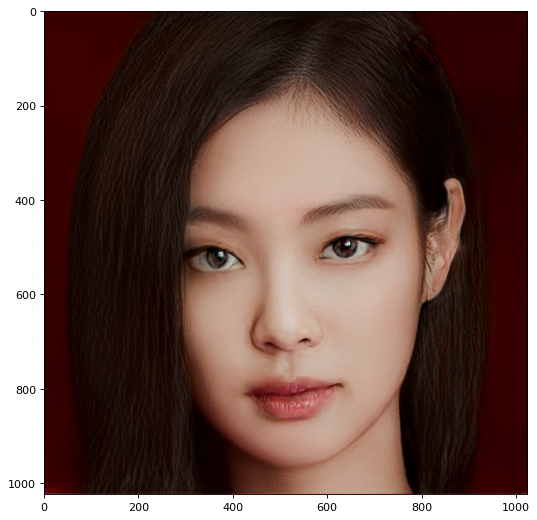

In [151]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # latent vector
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

src = 'images/제니.jpg'
name = '제니'
image = image_reader(src, resize=resolution)
image = image.to(device)

# Start the optimization
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # generate an image from a latent vector
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # calculate the gradient

    optimizer_latent.step() # update the latent vector

    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        # save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy()) # latent vector 저장

print("[ Embedding Result ]")
imshow(generated_image)